In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import wordnet as wn
import random
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel 


/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_32670/1063745375.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aumentation.rename(columns={'NAICS_2': 'NAICS'}, inplace=True)
/tmp/ipykernel_32670/1063745375.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aumentation['NAICS'] = df_aumentation['NAICS'].apply(lambda x: [x])
/tmp/ipykernel_32670/1063745375.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

                                               NAICS  \
0  [11, 11, 11, 22, 23, 32, 32, 48, 48, 48, 48, 4...   
1           [23, 23, 23, 32, 33, 33, 33, 33, 42, 48]   
2  [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...   
3                           [23, 23, 23, 23, 56, 56]   
4  [23, 23, 23, 23, 23, 23, 23, 23, 33, 33, 33, 3...   

                                BUSINESS_DESCRIPTION  
0  License Herbicide, Grass Mowing, Fence Install...  
1  Commercial and military professional aircraft ...  
2  CRL-Lovelady Construction, LLC, provides Gener...  
3  Summerlin Brothers, Inc. established 1996 has ...  
4  Design Build HVAC / General Construction. Faci...  
29651
                                BUSINESS_DESCRIPTION  11  21  22  23  31  32  \
0  License Herbicide, Grass Mowing, Fence Install...   1   0   1   1   0   1   
1  Commercial and military professional aircraft ...   0   0   0   1   0   1   
2  CRL-Lovelady Construction, LLC, provides Gener...   0   0   0   1   0   0   
3  Summ

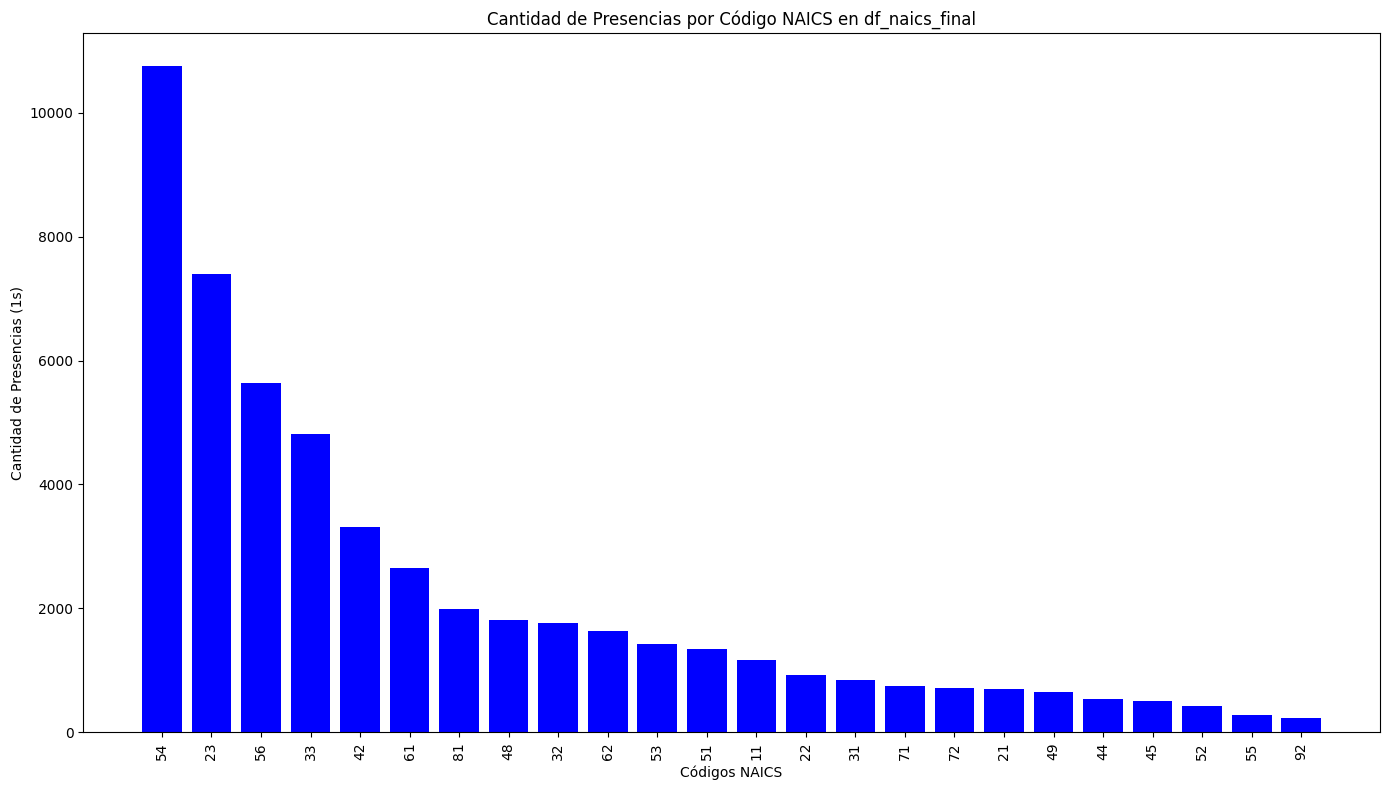

29651


In [19]:
ROUTE_SBA= '../src/data/sba_dataset.csv'
ROUTE_SBS= '../src/data/SBS_Certified_Business_List.csv' 
df_sba = pd.read_csv(ROUTE_SBA) 
df_sba = df_sba[['NAICS', 'DESCRIPTION_OF_OPERATIONS']]
df_sbs = pd.read_csv(ROUTE_SBS) 

df_certified_business_processed: pd.DataFrame = df_sbs.dropna(subset=['Business_Description'])[['ID6_digit_NAICS_code', 'Business_Description']]
df_certified_business_processed.columns = ['NAICS', 'BUSINESS_DESCRIPTION']
df_certified_business_processed['NAICS'] = df_certified_business_processed['NAICS'].astype(str)
df_certified_business_processed['NAICS'] = df_certified_business_processed['NAICS'].apply(lambda x: x.split(',') if isinstance(x, str) else [x])  


df_synthetic = pd.read_parquet('../src/data/synthetic_preprocessed.parquet')
df_aumentation = df_synthetic[['NAICS_2', 'BUSINESS_DESCRIPTION']]
df_aumentation.rename(columns={'NAICS_2': 'NAICS'}, inplace=True)
df_aumentation['NAICS'] = df_aumentation['NAICS'].apply(lambda x: [x])

df_clean_sba = df_sba.dropna()
df_clean_sba['NAICS'] = df_clean_sba['NAICS'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
df_clean_sba.rename(columns={'DESCRIPTION_OF_OPERATIONS': 'BUSINESS_DESCRIPTION'}, inplace=True) 
df_naics = pd.concat([df_clean_sba, df_certified_business_processed,df_aumentation], ignore_index=True)
df_naics['NAICS'] = df_naics['NAICS'].apply(lambda x: x if isinstance(x, list) else [x])

  
def truncate_naics_codes(df: pd.DataFrame, digits: int) -> pd.DataFrame:
   
    if 'NAICS' in df.columns:
        df['NAICS'] = df['NAICS'].apply(
            lambda naics_list: [str(code).strip()[:digits] for code in naics_list]
        )
    return df

df_naics=truncate_naics_codes(df_naics,2) 



print(df_naics.head())

print(df_naics.shape[0])



df_naics['NAICS'] = df_naics['NAICS'].apply(lambda x: list(set(x)))
expanded_naics = df_naics['NAICS'].explode()
dummies = pd.get_dummies(expanded_naics).groupby(expanded_naics.index).max()
df_naics_final = pd.concat([df_naics[['BUSINESS_DESCRIPTION']], dummies], axis=1)
naics_columns = df_naics_final.columns.difference(['BUSINESS_DESCRIPTION'])
df_naics_final[naics_columns] = df_naics_final[naics_columns].astype(int)
print(df_naics_final.head())


naics_columns = df_naics_final.columns.difference(['BUSINESS_DESCRIPTION'])
for col in naics_columns:
    print(f"Tipo de datos para la columna '{col}':", df_naics_final[col].dtype)
    print(f"Valores únicos en la columna '{col}':", df_naics_final[col].unique())
    print(f"Frecuencia de valores en la columna '{col}':")
    print(df_naics_final[col].value_counts())
    print("\n")  
    
naics_sums = df_naics_final[naics_columns].sum()
naics_sums_sorted = naics_sums.sort_values(ascending=False)
# Asegurarse de que las etiquetas de eje x son cadenas
naics_labels = [str(naic) for naic in naics_sums_sorted.index]

plt.figure(figsize=(14, 8))
plt.bar(naics_labels, naics_sums_sorted.values, color='blue')
plt.xlabel('Códigos NAICS')
plt.ylabel('Cantidad de Presencias (1s)')
plt.title('Cantidad de Presencias por Código NAICS en df_naics_final')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
print(df_naics.shape[0])

df_naics.to_csv('CORRECT_NAICS_BINARIZED.CSV',index=False)


                                              NAICS  \
0        ['56', '23', '22', '49', '32', '11', '48']   
1                    ['23', '33', '32', '42', '48']   
2                                            ['23']   
3                                      ['23', '56']   
4  ['81', '56', '23', '33', '53', '42', '62', '54']   

                                BUSINESS_DESCRIPTION  
0  License Herbicide, Grass Mowing, Fence Install...  
1  Commercial and military professional aircraft ...  
2  CRL-Lovelady Construction, LLC, provides Gener...  
3  Summerlin Brothers, Inc. established 1996 has ...  
4  Design Build HVAC / General Construction. Faci...  
29651
